In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

In [6]:
class Employee:
    def __init__(self, level, leave_rate, new_employee):
        # There are 4 possible levels: E, S, M, J
        if level in ['E', 'S', 'M', 'J']:
            self.level = level
        else:
            print("The level of teh employees must be E/S/M/J.")
        # Define the lamada of the employee
        self.leave_rate = leave_rate
        self.new_employee = new_employee
        self.seniority = None   # The time that a employee stays in the company
        self.time_at_level = None   # The time that a employee is at a certain level
        self.generate_seniority()
        self.time_until_depart = self.time_to_depart()

    def time_to_depart(self):
        # Generate a time to departure based on exponential distribution
        return np.random.exponential(1 / self.leave_rate)

    def generate_seniority(self):
        if self.new_employee == None:
            # We assume that the seniority at the beginning is a uniform and mixed value for different level
            seniority_base = {'E': 10, 'S': 5, 'M': 3, 'J': 1}
            seniority = np.random.uniform(seniority_base[self.level]-1, seniority_base[self.level]+1)
            self.seniority = seniority
            self.time_at_level = seniority
        else:
            new_employee_seniority_base = {'E': 0, 'S': 0, 'M': 0, 'J': 0}
            new_employee_seniority = np.random.uniform(0, new_employee_seniority_base[self.level])
            self.seniority = new_employee_seniority
            self.time_at_level = new_employee_seniority

    # Function for resetting employees' time at their level when they are promoted
    def reset_time_at_level(self):
        self.time_at_level = 0

class MaleEmployee(Employee):
    def __init__(self, level, leave_rate, new_employee):
        super().__init__(level, leave_rate, new_employee)


class FemaleEmployee(Employee):
    # Female have an additional timer kappa
    def __init__(self, level, leave_rate, kappa_rate, new_employee):
        self.kappa_rate = kappa_rate
        super().__init__(level, leave_rate, new_employee)

    def time_to_depart(self):
        # Generate a time to departure with additional factor for female employees
        female_leave_time = np.random.exponential(1 / (self.leave_rate + self.kappa_rate))
        return female_leave_time


class Company:
    def __init__(self, employee_profile, lambda_rate_set, kappa_rate_set, gamma, alpha):
        self.employees = {'E': [], 'S': [], 'M': [], 'J': []}
        # The profile is how many people in each of the level
        self.employee_profile = employee_profile
        self.lambda_rate_set = lambda_rate_set
        self.kappa_rate_set = kappa_rate_set
        self.gamma = gamma
        self.alpha = alpha
        # Additional attributes for tracking
        self.time = 0
        # Check how many people leave/retire
        self.vacancies = {'E': 0, 'S': 0, 'M': 0, 'J': 0}
        self.stats_tracker = StatisticsTracker()


    def lower_level(self, level):
        # This function returns the next lower level in the hierarchy
        levels = {'E': 'S', 'S': 'M', 'M': 'J'}
        return levels.get(level, None)  # Returns None if there is no lower level

    # Function for updating seniority
    def update_seniority(self):
        # Increment the seniority of each employee by one unit of time
        for level in ['E', 'S', 'M', 'J']:
            for employee in self.employees[level]:
                employee.seniority += 1
                employee.time_at_level += 1

    def check_retirements(self):
        # Iterate through each level and employee to check for retirements
        for level in ['E', 'S', 'M', 'J']:
            for employee in self.employees[level]:
                employee.time_until_depart -= 1
                if employee.time_until_depart <= 0:
                    self.employees[level].remove(employee)
                    self.vacancies[level] += 1

    # Promotions strictly based on seniority without bias
    def promotions_seniority(self):
        # Promote employees based on vacancies starting from the top level
        # J does not consider
        for level in ['E', 'S', 'M']:
            # if there is vacancy, and there is enough employees in junior level
            while self.vacancies[level] > 0 and self.employees[self.lower_level(level)]:
                # Find the most senior employee in the next lower level
                most_senior = max(self.employees[self.lower_level(level)], key=lambda e: e.seniority)
                
                self.employees[self.lower_level(level)].remove(most_senior)  # Remove the employee from their lower level
                most_senior.level = level  # Update the employee's level
                most_senior.reset_time_at_level()
                self.employees[level].append(most_senior)
                self.vacancies[level] -= 1
                self.vacancies[self.lower_level(level)] += 1  # New vacancy in the lower level

    # Promotions with bias towards seniority and gender
    def promotions_with_bias(self):
        for level in ['E', 'S', 'M']:
            while self.vacancies[level] > 0 and len(self.employees[self.lower_level(level)]) >= 3:
                # Get the three most senior candidates
                candidates = sorted(self.employees[self.lower_level(level)], 
                                    key=lambda e: e.time_at_level, reverse=True)[:3]
                probabilities = []
                for e in candidates:
                    bias_factor = self.alpha if isinstance(e, MaleEmployee) else 0
                    # Calculate promotion probabilities
                    promotion_probability = np.exp(self.gamma * e.time_at_level + bias_factor)
                    # print(e, promotion_probability)
                    probabilities.append(promotion_probability)
                    # print(probabilities)
                total_prob = sum(probabilities)

                # Choose a candidate based on probabilities
                chosen_candidate = np.random.choice(candidates, p=[p/total_prob for p in probabilities])
                
                self.employees[self.lower_level(level)].remove(chosen_candidate)
                chosen_candidate.level = level
                chosen_candidate.reset_time_at_level()
                self.employees[level].append(chosen_candidate)
                self.vacancies[level] -= 1
                self.vacancies[self.lower_level(level)] += 1

    def hire_new_employees(self):
        # Hire new employees to fill junior-level vacancies
        while self.vacancies['J'] > 0:
            gender = np.random.choice(['male', 'female'])
            new_employee = MaleEmployee('J', self.lambda_rate_set['J'], new_employee=True) if gender == 'male' \
                else FemaleEmployee('J', self.lambda_rate_set['J'], self.kappa_rate_set['J'], new_employee=True)
            self.employees['J'].append(new_employee)
            self.vacancies['J'] -= 1

    def get_gender_ratios(self):
        # Calculate and return the gender ratios at each level
        gender_ratios = {}
        for level in ['E', 'S', 'M', 'J']:
            male_count = sum(1 for e in self.employees[level] if isinstance(e, MaleEmployee))
            female_count = sum(1 for e in self.employees[level] if isinstance(e, FemaleEmployee))
            total_count = male_count + female_count
            gender_ratios[level] = {'male': male_count / total_count,
                                    'female': female_count / total_count} if total_count else {'male': 0, 'female': 0}
        return gender_ratios
    
    # Function to calculate the relaxation time
    def calculate_relaxation_time(self, gender_ratios, thresholds, consistency_requirement=33):
        tau_R = {level: None for level in gender_ratios}
        for level in gender_ratios:
            # Retrieve the specified threshold for the current level 
            threshold = thresholds[level]
            consistent_below_threshold = 0

            for i in range(1, len(gender_ratios[level])):
                rate_of_change = abs(gender_ratios[level][i] - gender_ratios[level][i - 1])
                
                if rate_of_change < threshold:
                    consistent_below_threshold += 1
                    # If the counter reaches the required consistency, record the time step
                    if consistent_below_threshold == consistency_requirement:
                        tau_R[level] = i - consistency_requirement + 1
                        break
                else:
                    consistent_below_threshold = 0

        return tau_R
    
    def run_simulation(self, duration, bias):
        # Data storage for plotting
        time_steps = [self.time]       # time_steps = [0]
        # gender_ratios = {'E': [self.get_gender_ratios()['E']['female']],
        #                  'S': [self.get_gender_ratios()['S']['female']],
        #                  'M': [self.get_gender_ratios()['M']['female']],
        #                  'J': [self.get_gender_ratios()['J']['female']]}

        gender_ratios = {'E': [], 'S': [], 'M': [], 'J': []}

        for _ in range(duration):
            if bias == None:
                self.simulate_year()
            else:
                self.simulate_year_bias()

            self.stats_tracker.update_statistics(self)
            time_steps.append(self.time)

            # Get current gender ratios
            for level in gender_ratios:
                gender_ratios[level].append(self.stats_tracker.data[level]['female_gender_ratio'][-1])

        return gender_ratios, self.stats_tracker.calculate_metrics()

    # No bias
    def simulate_year(self):
        # Simulate a year in the company, including retirements, promotions, and hiring
        self.time += 1
        # update seniority function
        self.update_seniority()
        self.check_retirements()
        self.promotions_seniority()
        self.hire_new_employees()
    
    # With bias
    def simulate_year_bias(self):
        self.time += 1
        self.update_seniority()
        self.check_retirements()
        self.promotions_with_bias()
        self.hire_new_employees()

class Company_All(Company):
    def __init__(self, employee_profile, lambda_rate_set, kappa_rate_set,  gamma, alpha, gender):
        super().__init__(employee_profile, lambda_rate_set, kappa_rate_set, gamma, alpha)
        self.gender = gender
        self.initialize_employees()  # Adjust this method for different initial states

    def initialize_employees(self):
        for level in self.employees:
            for _ in range(self.employee_profile[level]):
                if self.gender =='Male':
                    initial_employee = MaleEmployee(level, self.lambda_rate_set[level], new_employee=None)
                elif self.gender == 'Female':
                    initial_employee = FemaleEmployee(level, self.lambda_rate_set[level], self.kappa_rate_set[level], new_employee=None)
                else:
                    # Mixed - Equally likely 
                    self.gender = np.random.choice(['male', 'female'])
                    initial_employee = MaleEmployee(level, self.lambda_rate_set[level], new_employee=None) if self.gender == 'male' \
                    else FemaleEmployee(level, self.lambda_rate_set[level], self.kappa_rate_set[level], new_employee=None)
                self.employees[level].append(initial_employee)

    def plot_gender_ratios(self, time_steps, gender_ratios, gamma, alpha):
        plt.figure(figsize=(10, 6))
        for level in gender_ratios:
            plt.plot(time_steps[:len(gender_ratios[level])], gender_ratios[level], label=f'Level {level}')
        
        plt.xlabel('Time (Years)')
        plt.ylabel('Female Gender Ratio')
        if self.gender == 'Male':
            plt.title('Gender Ratio Trends Over Time by Level, Under All Male Initial')
        elif self.gender == 'Female':
            plt.title('Gender Ratio Trends Over Time by Level, Under All Female Initial')
        else:
            plt.title(f'Gender Ratio Trends Over Time by Level, Mixed, γ={gamma}, α={alpha}')

        plt.legend()
        plt.grid()
        plt.show()

class StatisticsTracker:
    def __init__(self):
        # Initialize dictionaries to store data for each level and metric
        self.data = {'E': {'female_gender_ratio': []},
                     'S': {'female_gender_ratio': []},
                     'M': {'female_gender_ratio': []},
                     'J': {'female_gender_ratio': []}}
        
        # self.data = {'E': {'seniority': [], 'female_gender_ratio': []},
        #              'S': {'seniority': [], 'female_gender_ratio': []},
        #              'M': {'seniority': [], 'female_gender_ratio': []},
        #              'J': {'seniority': [], 'female_gender_ratio': []}}

        # self.data = {'E': {'female_gender_ratio': [], 'seniority': [], 'time_at_level': []},
        #              'S': {'female_gender_ratio': [], 'seniority': [], 'time_at_level': []},
        #              'M': {'female_gender_ratio': [], 'seniority': [], 'time_at_level': []},
        #              'J': {'female_gender_ratio': [], 'seniority': [], 'time_at_level': []}}

    def update_statistics(self, company_state):
        """Update statistics based on the current state of the company."""
        for level in company_state.employees:
            male_count, female_count, total_seniority, total_time_at_level= 0, 0, 0, 0
            for employee in company_state.employees[level]:
                total_seniority += employee.seniority
                total_time_at_level += employee.time_at_level
                if isinstance(employee, MaleEmployee):
                    male_count += 1
                elif isinstance(employee, FemaleEmployee):
                    female_count += 1
            total_count = male_count + female_count

            # Calculate the average gender (seniority, time_at_level)
            gender_ratio = female_count / total_count if total_count != 0 else 0
            avg_seniority = total_seniority / total_count if total_count != 0 else 0
            avg_time_at_level = total_time_at_level / total_count if total_count != 0 else 0
            self.data[level]['female_gender_ratio'].append(gender_ratio)
            # self.data[level]['seniority'].append(avg_seniority)
            # self.data[level]['time_at_level'].append(avg_time_at_level)

    def calculate_metrics(self):
        """Calculate and return key metrics for each level."""
        metrics = {}
        for level in self.data:
            metrics[level] = {}
            for metric in self.data[level]:
                values = self.data[level][metric]
                mean = np.mean(values)
                ci = [mean - stats.sem(values) * 1.96, mean + stats.sem(values) * 1.96]   # 95% CI
                metrics[level][metric] = {'mean': mean, '95% CI': ci}

        # Create a dataframe to store the metrics
        transformed_data = []
        for level, metrics_dict in metrics.items():
            for metric, values in metrics_dict.items():
                row = {
                    'Level': level,
                    'Metric': metric,
                    'Mean': values['mean'],
                    '95% CI Lower': values['95% CI'][0],
                    '95% CI Upper': values['95% CI'][1]
                }
                transformed_data.append(row)

        metrics_df = pd.DataFrame(transformed_data)
        return metrics_df

class SimulationRunner:
    def __init__(self, company_class, employee_profile, lambda_rate_set, kappa_rate_set, gamma, alpha, gender):
        self.company_class = company_class
        self.employee_profile = employee_profile
        self.lambda_rate_set = lambda_rate_set
        self.kappa_rate_set = kappa_rate_set
        self.gamma = gamma
        self.alpha = alpha
        self.gender = gender

    def run_single_simulation(self, duration, bias):
        """Run a single simulation for the given duration."""
        company = self.company_class(self.employee_profile, self.lambda_rate_set, self.kappa_rate_set, self.gamma, self.alpha, self.gender)
        company.run_simulation(duration, bias)
        return company.stats_tracker.data

    def run_multiple_simulations(self, num_simulations, duration, bias):
        all_simulation_data = []
        for _ in range(num_simulations):
            simulation_data = self.run_single_simulation(duration, bias)
            all_simulation_data.append(simulation_data)
        return all_simulation_data

    def calculate_average_and_ci(self, simulation_data):
        """Calculate average and 95% CI for each metric across all simulations."""
        avg_data = {level: {'female_gender_ratio': {'mean': [], 'ci': []}} for level in ['E', 'S', 'M', 'J']}
        for level in avg_data:
            for time_step in range(len(simulation_data[0][level]['female_gender_ratio'])):
                time_step_data = [sim[level]['female_gender_ratio'][time_step] for sim in simulation_data]
                mean = np.mean(time_step_data)
                ci = stats.sem(time_step_data) * stats.t.ppf((1 + 0.95) / 2., len(time_step_data)-1)
                avg_data[level]['female_gender_ratio']['mean'].append(mean)
                avg_data[level]['female_gender_ratio']['ci'].append(ci)
        return avg_data

    def plot_results(self, avg_data, sample_paths=None):
        """Plot the average results with confidence intervals and sample paths."""
        plt.figure(figsize=(10, 6))
        time_steps = range(len(avg_data['E']['female_gender_ratio']['mean']))

        # Plot average and CI
        for level in avg_data:
            means = avg_data[level]['female_gender_ratio']['mean']
            cis = avg_data[level]['female_gender_ratio']['ci']
            plt.fill_between(time_steps, [m - c for m, c in zip(means, cis)], [m + c for m, c in zip(means, cis)], alpha=0.2)
            plt.plot(time_steps, means, label=f'{level} Average')

        plt.xlabel('Time (Years)')
        plt.ylabel('Fraction of Women')
        plt.title('Expected value and 95% CIs of Gender Ratio Over Time by Level')
        plt.grid()
        plt.legend()
        plt.show()

        # Plot sample paths
        for level in avg_data:
            plt.figure(figsize=(8, 5))
            
            if sample_paths:
                for i, path in enumerate(sample_paths):
                    plt.plot(time_steps, path[level]['female_gender_ratio'], label=f'Sample {i+1}', alpha=1)
            
            plt.xlabel('Time (Years)')
            plt.ylabel('Fraction of Women')
            plt.title(f'Gender Ratio Over Time - Level {level}')
            plt.grid()
            plt.legend()
            plt.show()


# 1. Simulation Models under Three Different Initial States

In this part, we will promote employees strictly based on seniority without any bias.

In [7]:
# Parameters
target_employees = {'E': 5, 'S': 20, 'M': 100, 'J': 400}
lambda_rate_set_user = {'E': 0.2, 'S': 0.25, 'M': 0.33, 'J': 0.5}
kappa_rate_set_user = {'E': 0.035, 'S': 0.044, 'M': 0.059, 'J': 0.088}
gamma = None    # Preference for seniority
alpha = None    # Bias towards selecting male candidates (can be +/-)
# Define the duration (in year) to simulate 
n_years = 100
# Define the thresholds to calculate the relaxation time
thresholds = {'E': 0.4, 'S': 0.3, 'M': 0.15, 'J': 0.1}

## 1.1 Initial States: All Male Employees

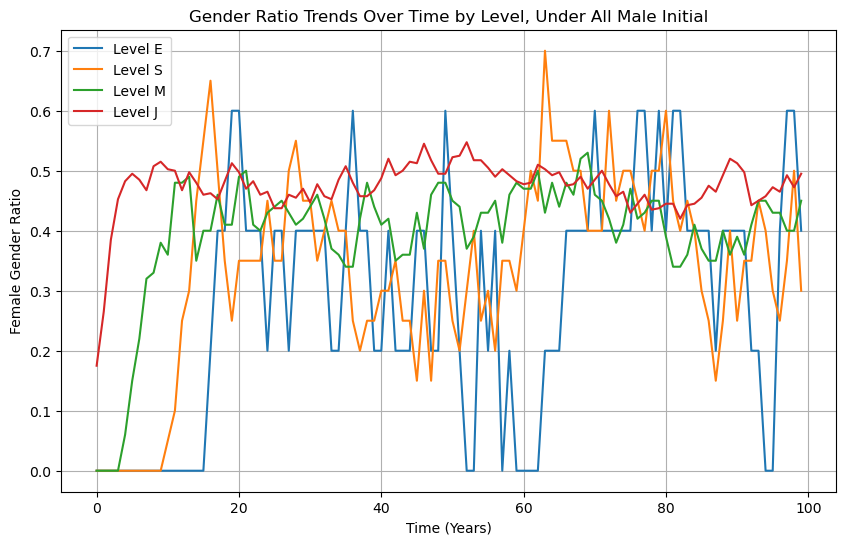

  Level               Metric      Mean  95% CI Lower  95% CI Upper
0     E  female_gender_ratio  0.282000      0.242961      0.321039
1     S  female_gender_ratio  0.335000      0.303221      0.366779
2     M  female_gender_ratio  0.395100      0.374469      0.415731
3     J  female_gender_ratio  0.473825      0.464752      0.482898
(All Male) Relaxation times for each level : {'E': 1, 'S': 1, 'M': 1, 'J': 3}


In [8]:
np.random.seed(1)
company_male = Company_All(target_employees, lambda_rate_set_user, kappa_rate_set_user, gamma, alpha, 'Male')
# Run the simulation for a given duration
gender_ratios, metrics = company_male.run_simulation(duration=n_years, bias=None)
tau_R_all_male = company_male.calculate_relaxation_time(gender_ratios, thresholds)

# Plot the results
company_male.plot_gender_ratios(np.arange(n_years + 1), gender_ratios, gamma, alpha)
# Print the results
print(metrics)
print("(All Male) Relaxation times for each level :", tau_R_all_male)

## 1.2 Initial States: All Female Employees

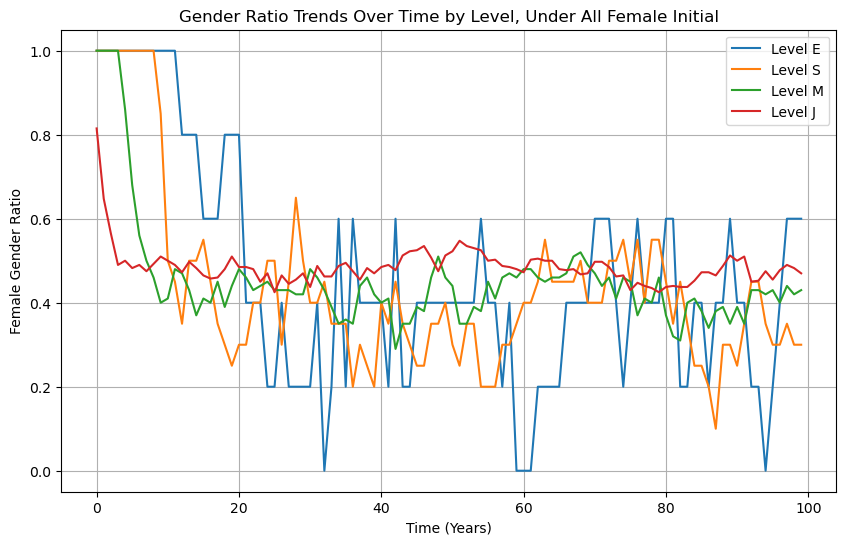

  Level               Metric      Mean  95% CI Lower  95% CI Upper
0     E  female_gender_ratio  0.464000      0.410885      0.517115
1     S  female_gender_ratio  0.436000      0.394960      0.477040
2     M  female_gender_ratio  0.453000      0.427136      0.478864
3     J  female_gender_ratio  0.486025      0.477005      0.495045
(All Female) Relaxation times for each level : {'E': 60, 'S': 11, 'M': 6, 'J': 2}


In [9]:
np.random.seed(1)
company_female = Company_All(target_employees, lambda_rate_set_user, kappa_rate_set_user, gamma, alpha, 'Female')
gender_ratios, metrics = company_female.run_simulation(duration=n_years, bias=None)
tau_R_all_female = company_female.calculate_relaxation_time(gender_ratios, thresholds)

# Plot the results
company_female.plot_gender_ratios(np.arange(n_years + 1), gender_ratios, gamma, alpha)
# Print the results
print(metrics)
print("(All Female) Relaxation times for each level :", tau_R_all_female)

## 1.3 Initial State: 50% Male Employees and 50% Female Employees

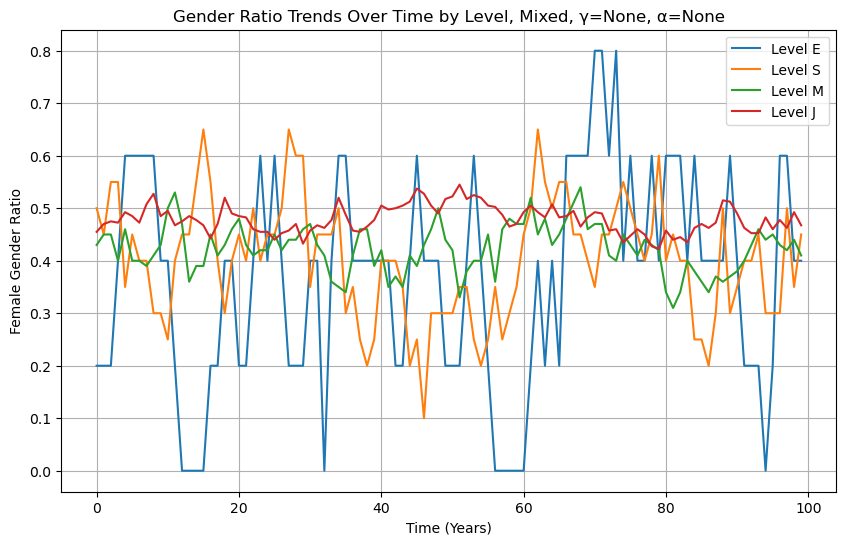

  Level               Metric      Mean  95% CI Lower  95% CI Upper
0     E  female_gender_ratio  0.370000      0.330064      0.409936
1     S  female_gender_ratio  0.401500      0.379412      0.423588
2     M  female_gender_ratio  0.422800      0.413743      0.431857
3     J  female_gender_ratio  0.479125      0.474021      0.484229
(Half M Half F) Relaxation times for each level : {'E': 34, 'S': 1, 'M': 1, 'J': 1}


In [10]:
np.random.seed(1)
company_mixed = Company_All(target_employees, lambda_rate_set_user, kappa_rate_set_user, gamma, alpha, 'Mixed')
gender_ratios, metrics = company_mixed.run_simulation(duration=n_years, bias=None)
tau_R_mixed = company_mixed.calculate_relaxation_time(gender_ratios, thresholds)

# Plot the results
company_mixed.plot_gender_ratios(np.arange(n_years + 1), gender_ratios, gamma, alpha)
# Print the results
print(metrics)
print("(Half M Half F) Relaxation times for each level :", tau_R_mixed)

To find a reasonable relaxation times for each level, we will run the simulation 1000 times and then find the average relaxation time for each level across all runs.

In [11]:
total_tau_R = {'E': 0, 'S': 0, 'M': 0, 'J': 0}
count_tau_R = {'E': 0, 'S': 0, 'M': 0, 'J': 0}
num_runs = 1000

for _ in range(num_runs):
    company_mixed = Company_All(target_employees, lambda_rate_set_user, kappa_rate_set_user, gamma, alpha, 'Mixed')
    gender_ratios, metrics = company_mixed.run_simulation(duration=n_years, bias=None)
    tau_R_mixed = company_mixed.calculate_relaxation_time(gender_ratios, thresholds)

    # Add the relaxation times from this run to the total, only if they are not None
    for level in total_tau_R:
        if tau_R_mixed[level] is not None:
            total_tau_R[level] += tau_R_mixed[level]
            count_tau_R[level] += 1

average_tau_R = {level: total_tau_R[level] / count_tau_R[level] if count_tau_R[level] > 0 else None for level in total_tau_R}

# Print
print("Average Relaxation Times:", average_tau_R)

Average Relaxation Times: {'E': 16.473684210526315, 'S': 2.943, 'M': 1.174, 'J': 1.0}


# 2. Run 100 Simulations for $5\tau$ Duration without Bias

In [7]:
# Parameters
target_employees = {'E': 5, 'S': 20, 'M': 100, 'J': 400}
lambda_rate_set_user = {'E': 0.9, 'S': 0.8, 'M': 0.7, 'J': 0.6}
kappa_rate_set_user = {'E': 0.05, 'S': 0.05, 'M': 0.05, 'J': 0.05}
gamma = None    # Preference for seniority
alpha = None    # Bias towards selecting male candidates (can be +/-)

# Parameters for the simulation
n_simulations = 100
tau_R = 25
# tau_R = 5 * max([value for value in tau_R_mixed.values() if value is not None])

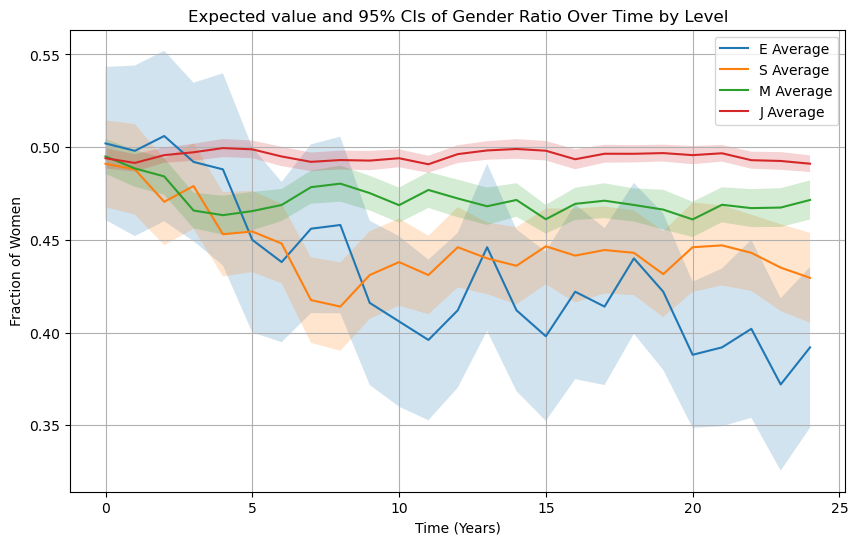

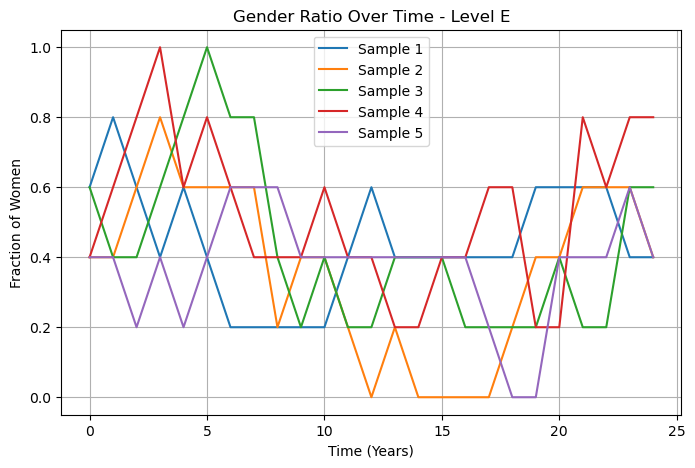

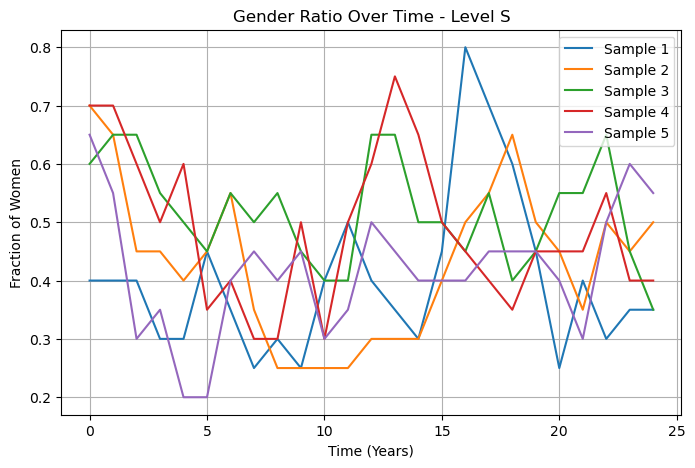

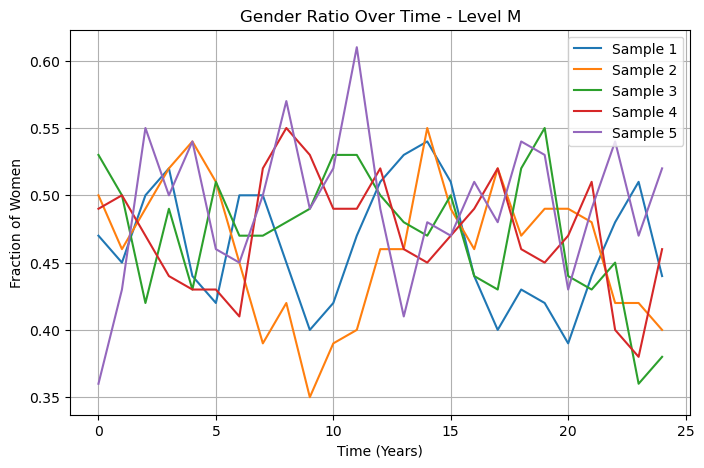

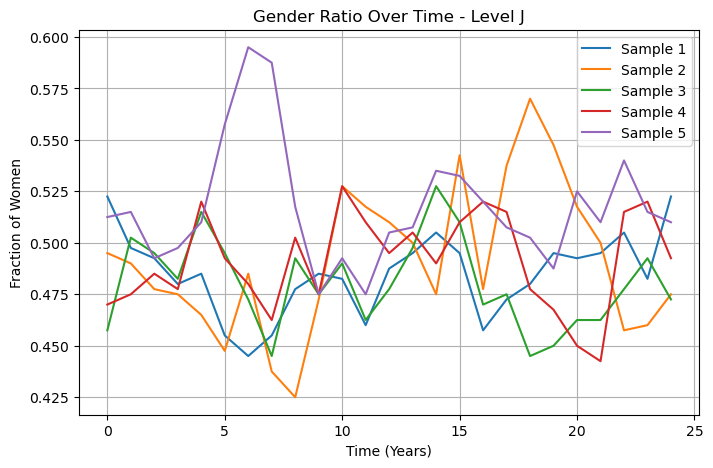

In [8]:
simulation_runner = SimulationRunner(Company_All, target_employees, lambda_rate_set_user, kappa_rate_set_user, gamma, alpha, 'Mixed')
all_simulation_data = simulation_runner.run_multiple_simulations(n_simulations, tau_R, bias=None)

# Calculate average and CI
avg_data = simulation_runner.calculate_average_and_ci(all_simulation_data)

# The first 5 sample paths
sample_paths = all_simulation_data[:5]
# Plots
simulation_runner.plot_results(avg_data, sample_paths=sample_paths)

# 3. Simulation Model with Bias

In this part, the three seniormost candidates at each level are chosen for promotion with probability proportional to $e^{\gamma T_i+\alpha \mathbb{1}[\text{i is male}]}$, where $\gamma$ represents a preference for seniority and $\alpha$ represents a bias towards selecting male candidates.

In [9]:
# Parameters
target_employees = {'E': 5, 'S': 20, 'M': 100, 'J': 400}
lambda_rate_set_user = {'E': 0.2, 'S': 0.25, 'M': 0.33, 'J': 0.5}
kappa_rate_set_user = {'E': 0.035, 'S': 0.044, 'M': 0.059, 'J': 0.088}
gamma = 1    # Preference for seniority
alpha_values = [-2.944, 2.944]    # Bias towards selecting male candidates (can be +/-)
# Define the duration (in years) to simulate 
n_years = 100
levels = ['E', 'S', 'M', 'J']

<Figure size 640x480 with 0 Axes>

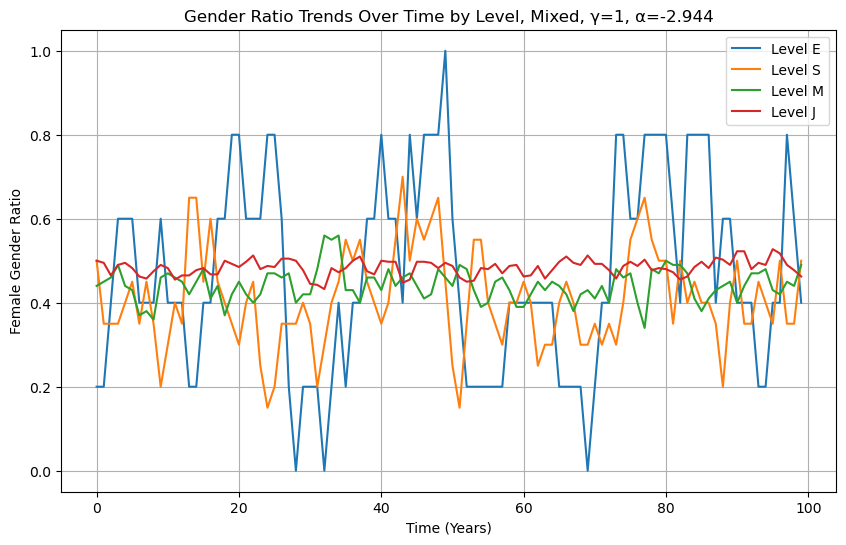

Metrics for alpha = -2.944:
  Level               Metric    Mean  95% CI Lower  95% CI Upper
0     E  female_gender_ratio  0.4720      0.426558      0.517442
1     S  female_gender_ratio  0.4090      0.386524      0.431476
2     M  female_gender_ratio  0.4417      0.434096      0.449304
3     J  female_gender_ratio  0.4836      0.479926      0.487274


<Figure size 640x480 with 0 Axes>

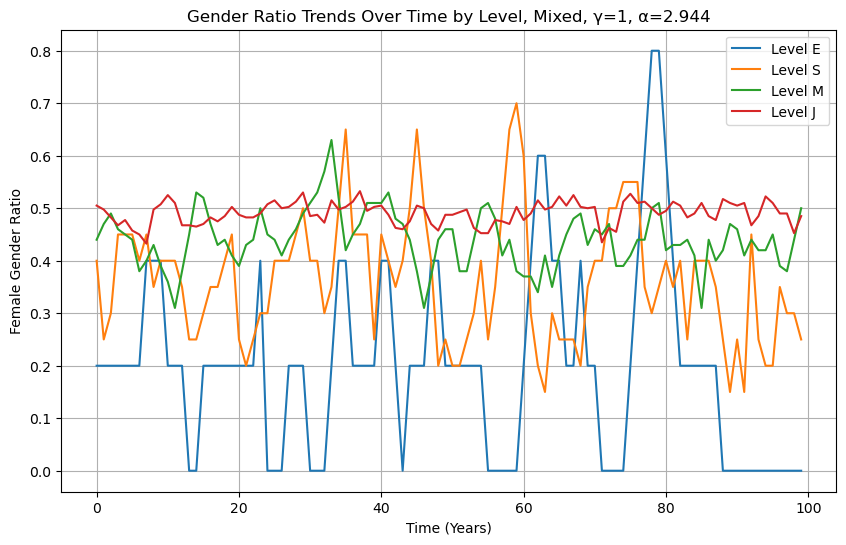

Metrics for alpha = 2.944:
  Level               Metric      Mean  95% CI Lower  95% CI Upper
0     E  female_gender_ratio  0.200000      0.164762      0.235238
1     S  female_gender_ratio  0.363000      0.339875      0.386125
2     M  female_gender_ratio  0.440300      0.429596      0.451004
3     J  female_gender_ratio  0.490625      0.486428      0.494822


In [10]:
for alpha in alpha_values:
    np.random.seed(12)
    company_with_bias = Company_All(target_employees, lambda_rate_set_user, kappa_rate_set_user, gamma, alpha, 'Mixed')
    gender_ratios, metrics = company_with_bias.run_simulation(duration=n_years, bias=True)

    # Plot the results for each alpha
    plt.figure()
    company_with_bias.plot_gender_ratios(np.arange(n_years + 1), gender_ratios, gamma, alpha)

    # Print the results for each alpha
    print(f"Metrics for alpha = {alpha}:")
    print(metrics)

Level E:
  Alpha -2.944: Average Ratio = 0.4720
  Alpha 2.944: Average Ratio = 0.2000

Level S:
  Alpha -2.944: Average Ratio = 0.4090
  Alpha 2.944: Average Ratio = 0.3630

Level M:
  Alpha -2.944: Average Ratio = 0.4417
  Alpha 2.944: Average Ratio = 0.4403

Level J:
  Alpha -2.944: Average Ratio = 0.4836
  Alpha 2.944: Average Ratio = 0.4906



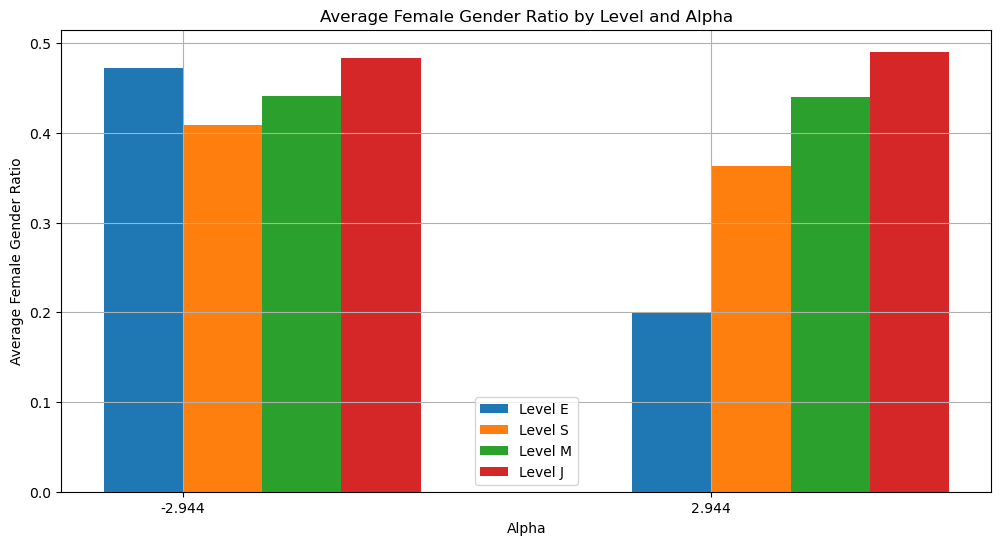

In [11]:
average_ratios = {level: {alpha: None for alpha in alpha_values} for level in levels}

# Run simulation for each alpha and store average gender ratios
for alpha in alpha_values:
    np.random.seed(1)
    company_with_bias = Company_All(target_employees, lambda_rate_set_user, kappa_rate_set_user, gamma, alpha, 'Mixed')
    gender_ratios, _ = company_with_bias.run_simulation(duration=n_years, bias=True)
    for level in levels:
        average_ratios[level][alpha] = np.mean(gender_ratios[level])

plt.figure(figsize=(12, 6))

# Parameters for the histogram
n_levels = len(levels)
width = 0.15  # Width of the bars in the histogram

# Create a histogram for each level
for i, level in enumerate(levels):
    # Calculate position of each bar
    positions = np.arange(len(alpha_values)) + i * width
    
    # Heights of the bars (average ratios)
    heights = [average_ratios[level][alpha] for alpha in alpha_values]
    
    # Plot
    plt.bar(positions, heights, width, label=f'Level {level}')

    # Print
    print(f"Level {level}:")
    for alpha in alpha_values:
        print(f"  Alpha {alpha}: Average Ratio = {average_ratios[level][alpha]:.4f}")
    print()  # Just for better formatting

# Add labels, title, and legend
plt.xlabel('Alpha')
plt.ylabel('Average Female Gender Ratio')
plt.title('Average Female Gender Ratio by Level and Alpha')
plt.xticks(np.arange(len(alpha_values)) + width / 2, alpha_values)
plt.legend()
plt.grid()
plt.show()